### adapted from locuslab/TCN

#### importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import csv
import re
from matplotlib import cm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
import random

In [2]:
from ray import tune

In [3]:
from functools import partial
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from filelock import FileLock
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler

#### data cleaning

In [4]:
def data_cleaning(path, pattern_interest): 
    # reading in the data
    data = pd.read_csv(path,header=0)
    # sorting data in dataframe
    df1 = pd.DataFrame(data)
    
    #getting only the step 11 related variables
    step11vars = [col for col in df1.columns if col.split('.')[0] == '11']
    df2 = df1.loc[:, df1.columns.isin(step11vars)]
    
    # getting only the faceplate, bottom heater and heater outerzone related variables within the step11 dataset

    # bottom heater related
    bottom_related = [col for col in df2.columns if 'Bottom' in col]
    dfb = df2.loc[:, df2.columns.isin(bottom_related)]

    # faceplate related
    faceplate_related = [col for col in df2.columns if "Faceplate" in col]
    dff = df2.loc[:, df2.columns.isin(faceplate_related)]

    # heater outer-zone related
    outer_related = [col for col in df2.columns if "HeaterOuter" in col]
    dfo = df2.loc[:, df2.columns.isin(outer_related)]
    
    # heater exchanger related
    hx_related = [col for col in df2.columns if "HX" in col]
    dfx = df2.loc[:, df2.columns.isin(hx_related)]
    
    # heater exchanger related
    inner_related = [col for col in df2.columns if "HeaterInner" in col]
    dfi = df2.loc[:, df2.columns.isin(inner_related)]
    
    # merge the three keywords related datasets together into `dfall`
    dfall = pd.concat([dfb, dff, dfo, dfx, dfi], axis=1)
    
    mean_related = [col for col in dfall.columns if "mean" in col]
    dfmean = dfall.loc[:, dfall.columns.isin(mean_related)]
    
    #Xbotmean = dfmean[dfmean.columns.drop(list(dfmean.filter(regex='11.FaceplateHeater_Temperature.mean')))]
    Xmean = dfmean[dfmean.columns.drop(list(dfmean.filter(regex=pattern_interest)))]
    ymean = dfmean.loc[:,[pattern_interest]]
    
    return Xmean, ymean

#### TCN module

In [5]:
from torch.nn.utils import weight_norm

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

#### upper level of the TCN model

In [6]:
from torch import nn
import torch.nn.functional as F

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights() # if the data needs to be weighted

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)  # if multidimensional, input should have dimension (N, C, L)
        o = self.linear(y1[:, :, -1])
        return o

#### data generator for the adding problem

In [7]:
from torch.autograd import Variable

def data_generator(percent_train, seq_length, path):
    
    """
    Args:
        seq_length: Length of the adding problem data
        starting_index: the index of where the sequence starts; starting from 0
    """
    # Specifying the feature columns that we need for predictions
    col1 = '11.BottomHeater_Temperature.mean'
    col2 = '11.FaceplateHeater_Temperature.mean'
    col3 = '11.HeaterOuterZone_Temperature.mean'
    col = [col1, col2, col3]
    
    # Giving the path to the data set
    csv = path
    
    # Data cleaning, getting the feature matrix and 
    X_bot, y_bot = data_cleaning(csv, col1)
    
    X_bot = torch.tensor(X_bot.to_numpy()).float()
    y_bot = torch.tensor(y_bot.to_numpy()).float()
    print("converted X_bot ", X_bot.shape, "and y_bot ", y_bot.shape, " to tensors\n")
    
    X_bot1 = torch.reshape(X_bot, [1, X_bot.shape[1], X_bot.shape[0]]) #[1,14,274]
    y_bot1 = torch.reshape(y_bot, [1, y_bot.shape[0]]) #[1,274]

    first_test_idx = int(round(percent_train * X_bot.shape[0]))
    X_train = X_bot1[:, :, 0:first_test_idx]
    X_test = X_bot1[:, :, first_test_idx:]
    y_train = y_bot1[:, 0:first_test_idx]
    y_test = y_bot1[:, first_test_idx:]
    
    X_train_final = torch.zeros([X_train.shape[2]-seq_length, X_train.shape[1], seq_length]) #[196, 14, 10] = [206-10, 14, 10]
    y_train_final = torch.zeros([y_train.shape[1]-seq_length, 1]) #[196, 1] = [206-10, 1]
    X_test_final = torch.zeros([X_test.shape[2]-seq_length, X_test.shape[1], seq_length]) #[58, 14, 10] = [68-10, 14, 10]
    y_test_final = torch.zeros([y_test.shape[1]-seq_length, 1]) #[58,1] = [68-10, 1]
    
    for i in range(X_train.shape[2]-seq_length):
        X_train_final[i, :, :] = X_train[: , : , i:i+seq_length]
        y_train_final[i, :] = y_train[: , i+seq_length:i+seq_length+1]
        
    for i in range(X_test.shape[2]-seq_length):
        X_test_final[i, :, :] = X_test[: , : , i:i+seq_length]
        y_test_final[i, :] = y_test[: , i+seq_length:i+seq_length+1]
#         print("at index i = ", i, "y_test[1, ", i+seq_length, "] = ",y_test[: , i+seq_length:i+seq_length+1])
#         print("at index i = ", i, "y_test_final[",i, ", :] = ", y_test_final[i, :])

    
#     print("Y_train shape is set to: ", y_train_final.shape, "; Y_train type is: ", type(y_train_final), "\n")
#     print("X_train shape is set to: ", X_train_final.shape, "; X_train type is: ", type(X_train_final), "\n")
#     print("Y_test shape is set to: ", y_test_final.shape, "; Y_test type is: ", type(y_test_final), "\n")
#     print("X_test shape is set to: ", X_test_final.shape, "; X_test type is: ", type(X_test_final), "\n")    
    
    return Variable(X_train_final), Variable(y_train_final), Variable(X_test_final), Variable(y_test_final)

#### parameters needed for the program

In [8]:
input_channels = 14 # # of input features
n_classes = 1  #size of each output sample; output feature sizes of y_pred
batch_size = 16 #batch size defaults to 32
seq_length = 5 #sequence length; defaults to 400
epochs = 10 #upper epoch limit; defaults to 10
clip = -1 #args.clip; gradient clip, -1 means no clip (default: -1)
log_interval = 100 #args.log_interval; 'report interval (default: 100')
channel_sizes = [70]*2 #[args.nhid]*args.levels; number of hidden units per layer * # of levels
kernel_size = 5 #args.ksize; kernel_size
dropout =  0.0 #args.dropout; dropouts applied to each layer; defaults to 0.0
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)
lr = 0.0027257365073673117 # learning rate is defaulted to be 0.0040
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #optimizer = getattr(optim, args.optim)(model.parameters(), lr=lr)

In [9]:
percent = 0.8
X_train, Y_train, X_test, Y_test = data_generator(percent, seq_length, r"C:\Users\e177321\Documents\data\Marathon_data.csv")
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

converted X_bot  torch.Size([274, 14]) and y_bot  torch.Size([274, 1])  to tensors

torch.Size([214, 14, 5]) torch.Size([214, 1]) torch.Size([50, 14, 5]) torch.Size([50, 1])


In [10]:
type(Y_test)

torch.Tensor

#### training

In [11]:
def train(epoch, input_channels=14):
    global lr
    
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size)], Y_train[i:(i+batch_size)]
            
        #print("x.shape = ", x.shape, "y.shape = ", y.shape)
        optimizer.zero_grad()
        output = model(x)
        loss = torch.nn.functional.mse_loss(output, y)
        loss.backward()
        if clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % log_interval == 0:
            cur_loss = total_loss / log_interval
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0

#### testing

In [12]:
def evaluate():
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = torch.nn.functional.mse_loss(output, Y_test)
        print('\nTest set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return Y_test, output, test_loss.item()

In [13]:
type(Y_test)

torch.Tensor


Test set: Average loss: 837.386414


Test set: Average loss: 17.486008


Test set: Average loss: 39.842075


Test set: Average loss: 1.321211


Test set: Average loss: 0.679870


Test set: Average loss: 0.067076


Test set: Average loss: 0.042416


Test set: Average loss: 0.115663


Test set: Average loss: 0.014595


Test set: Average loss: 0.018467

min loss found in ep  8 : minloss =  0.014594539068639278 



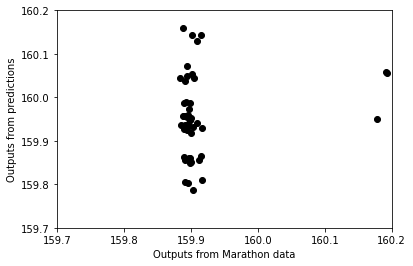

In [14]:
loss = []
lstoutput = []
lstytest = []
for ep in range(1, epochs+1):
    train(ep)
    ytest, output, test_loss = evaluate()  
    loss.append(test_loss)
    lstoutput.append(output.tolist())
    lstytest.append(ytest.tolist())

    minloss = min(loss)
    minidx = loss.index(minloss)

    ytest = lstytest[minidx]
    output = lstoutput[minidx]

print("min loss found in ep ", minidx, ": minloss = ", minloss, "\n")

f, ax = plt.subplots()
ax.scatter(ytest, output,  color='black')
ax.set_xlabel('Outputs from Marathon data')
ax.set_ylabel('Outputs from predictions')

plt.xlim(159.7,160.20)
plt.ylim(159.7,160.20)
#plt.gca().set_aspect('equal', adjustable='box')
figname = "bottom_tcn_opt"
ax.figure.savefig(figname, dpi=300)

**seq_length = 3:** min loss found in ep  7 : minloss =  0.046425484120845795 <br>
**seq_length = 5:** min loss found in ep  6 : minloss =  0.03591875731945038  <br>
**seq_length = 6:** min loss found in ep  6 : minloss =  0.0220029279589653   <br>
**seq_length = 7:** min loss found in ep  8 : minloss =  0.024872690439224243 <br>
**seq_length = 8:** min loss found in ep  8 : minloss =  0.0209933053702116   <br>
**seq_length = 9** min loss found in ep  9 : minloss =  0.022520944476127625   <br>
**seq_length = 10:** min loss found in ep  9 : minloss =  0.0950486958026886  <br>
**seq_length = 12:** min loss found in ep  9 : minloss =  0.20230647921562195  <br>
**seq_length = 15:** min loss found in ep  9 : minloss =  0.03576983883976936  <br>
**seq_length = 20**min loss found in ep  8 : minloss =  0.11364954710006714  <br>

In [15]:
# def evaluate():
#     model.eval()
#     with torch.no_grad():
#         output = model(X_test)
#         test_loss = torch.nn.functional.mse_loss(output, Y_test)
#         print('\nTest set: Average loss: {:.6f}\n'.format(test_loss.item()))
#         return test_loss

# #loss = []

# eploss = []

# for i in [5, 10, 12, 15, 18, 20, 25, 30]:
#     loss = []
#     epochs = i
#     for ep in range(1, epochs+1):
#         train(ep)
#         test_loss = evaluate()  
#         loss.append(test_loss.item())

#         minloss = min(loss)
#         minidx = loss.index(minloss)
        
#     print("when epoch = ", i, " minloss = ", minloss, "\n")
#     eploss.append([i, minloss])

when epoch =  5  minloss =  1.8050010204315186 <br>
when epoch =  10  minloss =  0.02135978452861309 <br>
when epoch =  12  minloss =  0.013690745458006859 <br>
when epoch =  15  minloss =  0.013690745458006859<br>
when epoch =  20  minloss =  0.013690745458006859 <br>
when epoch =  25  minloss =  0.012305893003940582 <br>
when epoch =  30  minloss =  0.012305893003940582 <br>

In [16]:
# eploss = np.array(eploss)
# figep, axep = plt.subplots()
# plt.plot(eploss[:,0],eploss[:,1])
# plt.scatter(eploss[:,0],eploss[:,1])
# axep.figure.savefig("ep_effect.png", dpi=300)

**seq_length = 3:** min loss found in ep  7 : minloss =  0.046425484120845795 <br>
**seq_length = 5:** min loss found in ep  6 : minloss =  0.03591875731945038  <br>
**seq_length = 6:** min loss found in ep  6 : minloss =  0.0220029279589653   <br>
**seq_length = 7:** min loss found in ep  8 : minloss =  0.024872690439224243 <br>
**seq_length = 8:** min loss found in ep  8 : minloss =  0.0209933053702116   <br>
**seq_length = 9** min loss found in ep  9 : minloss =  0.022520944476127625   <br>
**seq_length = 10:** min loss found in ep  9 : minloss =  0.0950486958026886  <br>
**seq_length = 12:** min loss found in ep  9 : minloss =  0.20230647921562195  <br>
**seq_length = 15:** min loss found in ep  9 : minloss =  0.03576983883976936  <br>
**seq_length = 20**min loss found in ep  8 : minloss =  0.11364954710006714  <br>

In [17]:
# seqloss = np.array(losscomp)
# figseq, axseq = plt.subplots()
# axseq.plot(seqloss[:,0], seqloss[:, 1])
# axseq.scatter(seqloss[:,0], seqloss[:, 1])
# axseq.figure.savefig("seq_length_effect", dpi=300)

In [18]:
# a = min(seqloss[:,1])
# print(a) 

In [19]:
# losscomp